In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import eli5

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,8)
cmap_train, cmap_test = "bone", "plasma"

## Classification

In [3]:
df = pd.read_csv('data/processed.csv')
X_train, X_test, y_train, y_test = train_test_split(df.readme, df.language,
                    test_size=.22, random_state=0, stratify=df.language)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   repo       701 non-null    object
 1   language   701 non-null    object
 2   readme     701 non-null    object
 3   words      701 non-null    int64 
 4   lang_freq  701 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 27.5+ KB
None


In [4]:
pd.DataFrame(df.language.value_counts())

,language
Go,106
Python,102
Java,102
C++,100
Swift,100
JavaScript,97
C,94


In [5]:
def report_and_conf_matrix(clf, X, y, cmap=cmap_train):
    scores = cross_val_score(estimator=clf, X=X, y=y)
    moments = [scores.mean(), scores.std()]
    print("-------MAXIMIZE THIS-------\nCross-validation mean accuracy: %0.3f (stdev %0.3f)\n---------------------------" % (moments[0], moments[1]))
    print(np.round(scores,3))
    print(classification_report(y, clf.predict(X)))
    plot_confusion_matrix(clf, X, y, values_format='.0f', cmap=cmap)
    return moments

### Dummy (baseline)

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.135 (stdev 0.018)
---------------------------
[0.155 0.138 0.11  0.156 0.119]
              precision    recall  f1-score   support

           C       0.11      0.12      0.12        73
         C++       0.13      0.12      0.12        78
          Go       0.21      0.22      0.22        83
        Java       0.14      0.13      0.13        79
  JavaScript       0.19      0.17      0.18        76
      Python       0.11      0.13      0.12        79
       Swift       0.18      0.19      0.19        78

    accuracy                           0.15       546
   macro avg       0.15      0.15      0.15       546
weighted avg       0.16      0.15      0.15       546



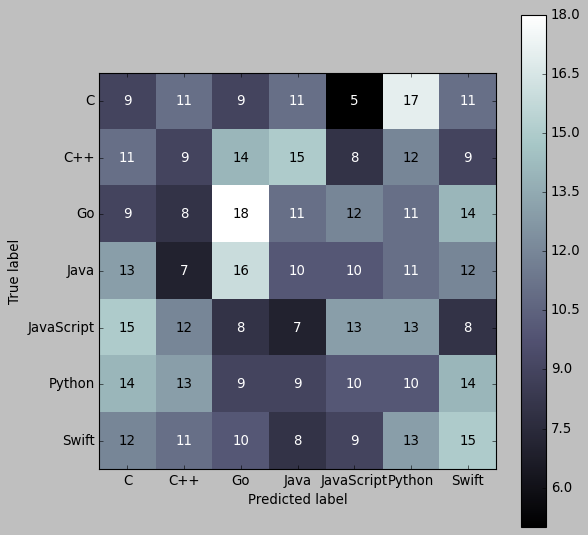

In [6]:
clf = DummyClassifier(strategy='stratified', random_state=2)
clf.fit(X_train, y_train)
clfmom = report_and_conf_matrix(clf, X=X_train, y=y_train)

### Naive Bayes

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.720 (stdev 0.018)
---------------------------
[0.745 0.716 0.706 0.734 0.697]
              precision    recall  f1-score   support

           C       0.90      0.78      0.84        73
         C++       0.86      0.86      0.86        78
          Go       0.81      0.96      0.88        83
        Java       0.89      0.96      0.93        79
  JavaScript       0.95      0.82      0.88        76
      Python       0.90      0.87      0.88        79
       Swift       0.97      0.99      0.98        78

    accuracy                           0.89       546
   macro avg       0.90      0.89      0.89       546
weighted avg       0.90      0.89      0.89       546



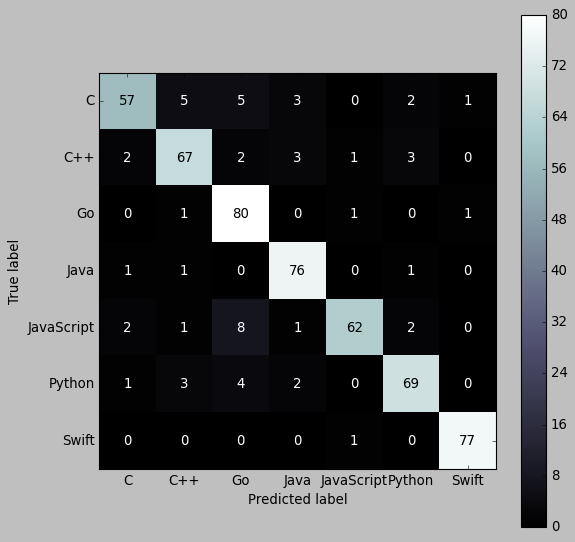

In [11]:
nb_clf = MultinomialNB()
nb_vec = TfidfVectorizer(max_features=900)
X = nb_vec.fit_transform(X_train)
nb_clf.fit(X.todense(), y_train)
nbmom = report_and_conf_matrix(nb_clf, X=X.todense(), y=y_train)

### Logistic regression

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.729 (stdev 0.037)
---------------------------
[0.782 0.752 0.697 0.734 0.679]
              precision    recall  f1-score   support

           C       0.93      0.88      0.90        73
         C++       0.88      0.86      0.87        78
          Go       0.90      0.98      0.94        83
        Java       0.94      0.95      0.94        79
  JavaScript       0.92      0.89      0.91        76
      Python       0.90      0.92      0.91        79
       Swift       1.00      0.97      0.99        78

    accuracy                           0.92       546
   macro avg       0.92      0.92      0.92       546
weighted avg       0.92      0.92      0.92       546



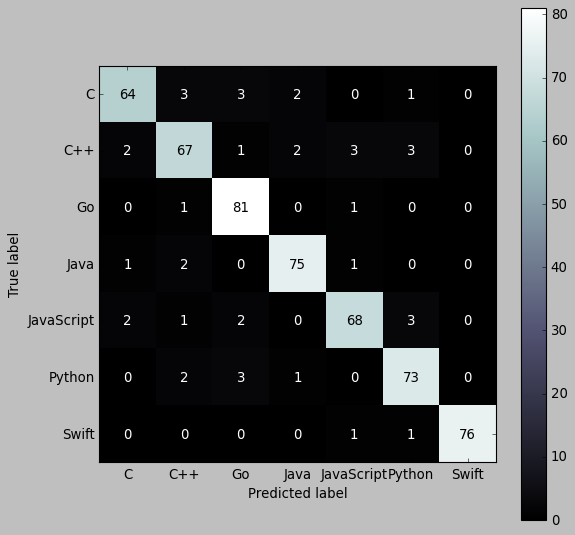

In [14]:
lr_clf = LogisticRegression(C=1)
lr_vec = TfidfVectorizer(min_df=40, max_df=.4)
X = lr_vec.fit_transform(X_train)
lr_clf.fit(X, y_train)
lrmom = report_and_conf_matrix(lr_clf, X=X, y=y_train)

In [102]:
eli5.explain_weights(lr_clf, feature_names=list(lr_vec.vocabulary_.keys()))

Explanation(estimator="LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='auto', n_jobs=None, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='C', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='warn', weight=1.0217708580480989, std=None, value=None), FeatureWeight(feature='solut', weight=1.0191281428051784, std=None, value=None), FeatureWeight(feature='blue', weight=0.9836053114260256, std=None, value=None), FeatureWeight(feature='machin', weight=0.9012385417343652, std=None, value=None), FeatureWeight(feature='campaign', weight=0.8996892502442178, std=None, value=None), FeatureWeight(feature='privat', weight=0.8959815544647518, std=None, value=None), FeatureWeight(feature='content', weight=0.8452686605647134, std=None, value=None), FeatureWeight(feature='name', weight=0.7908350988631357, std=None, value=None), FeatureWeight(feature='password', weight=0.7387949993366895, std=None, value=None), FeatureWeight(feature='push', weight=0.7314421057244558, std=None, value=None), FeatureWeight(feature='overrid', weight=0.7024947422267714, std=None, value=None), FeatureWeight(feature='ignor', weight=0.6562983923704542, std=None, value=None), FeatureWeight(feature='rang', weight=0.6488291683640506, std=None, value=None), FeatureWeight(feature='valu', weight=0.6448420033712945, std=None, value=None), FeatureWeight(feature='second', weight=0.6291762579125951, std=None, value=None), FeatureWeight(feature='stream', weight=0.6274965001421524, std=None, value=None)], neg=[FeatureWeight(feature='buffer', weight=-1.0164938495487823, std=None, value=None), FeatureWeight(feature='associ', weight=-0.9551774537817042, std=None, value=None), FeatureWeight(feature='gitter', weight=-0.905881073380091, std=None, value=None), FeatureWeight(feature='consist', weight=-0.6300723117866206, std=None, value=None)], pos_remaining=359, neg_remaining=361), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='C++', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='qualiti', weight=0.8885445343580365, std=None, value=None), FeatureWeight(feature='descript', weight=0.8788685816069988, std=None, value=None), FeatureWeight(feature='super', weight=0.8334507409995248, std=None, value=None), FeatureWeight(feature='interfac', weight=0.8236784170678603, std=None, value=None), FeatureWeight(feature='bind', weight=0.7991315712822001, std=None, value=None), FeatureWeight(feature='content', weight=0.7456802851829455, std=None, value=None), FeatureWeight(feature='multi', weight=0.7325202434483556, std=None, value=None), FeatureWeight(feature='templat', weight=0.7269023890077186, std=None, value=None), FeatureWeight(feature='js', weight=0.7203258295335287, std=None, value=None), FeatureWeight(feature='fork', weight=0.7197856257653046, std=None, value=None), FeatureWeight(feature='short', weight=0.7143796975092427, std=None, value=None), FeatureWeight(feature='introduct', weight=0.6847139074543631, std=None, value=None), FeatureWeight(feature='campaign', weight=0.6665036914554469, std=None, value=None), FeatureWeight(feature='close', weight=0.6662802935715062, std=None, value=None), FeatureWeight(feature='etc', weight=0.6

### kNN

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.658 (stdev 0.040)
---------------------------
[0.655 0.725 0.633 0.67  0.606]
              precision    recall  f1-score   support

           C       0.55      0.49      0.52        73
         C++       0.55      0.45      0.49        78
          Go       0.66      0.78      0.71        83
        Java       0.74      0.89      0.81        79
  JavaScript       0.73      0.72      0.73        76
      Python       0.73      0.66      0.69        79
       Swift       0.88      0.87      0.88        78

    accuracy                           0.70       546
   macro avg       0.69      0.69      0.69       546
weighted avg       0.69      0.70      0.69       546



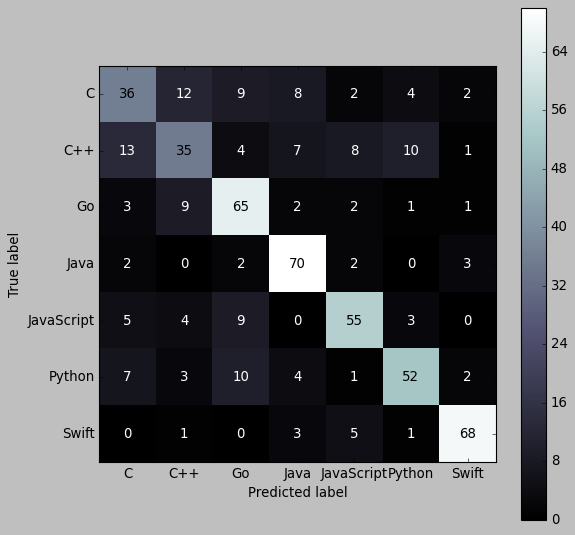

In [15]:
knn_clf = KNeighborsClassifier(n_neighbors=13)
knn_vec = TfidfVectorizer(min_df=25, max_df=.35)
X = knn_vec.fit_transform(X_train)
knn_clf.fit(X, y_train)
knnmom = report_and_conf_matrix(knn_clf, X=X, y=y_train)

### Random forest

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.775 (stdev 0.029)
---------------------------
[0.782 0.78  0.771 0.817 0.725]
              precision    recall  f1-score   support

           C       0.99      1.00      0.99        73
         C++       1.00      1.00      1.00        78
          Go       1.00      1.00      1.00        83
        Java       1.00      1.00      1.00        79
  JavaScript       1.00      1.00      1.00        76
      Python       1.00      0.99      0.99        79
       Swift       1.00      1.00      1.00        78

    accuracy                           1.00       546
   macro avg       1.00      1.00      1.00       546
weighted avg       1.00      1.00      1.00       546



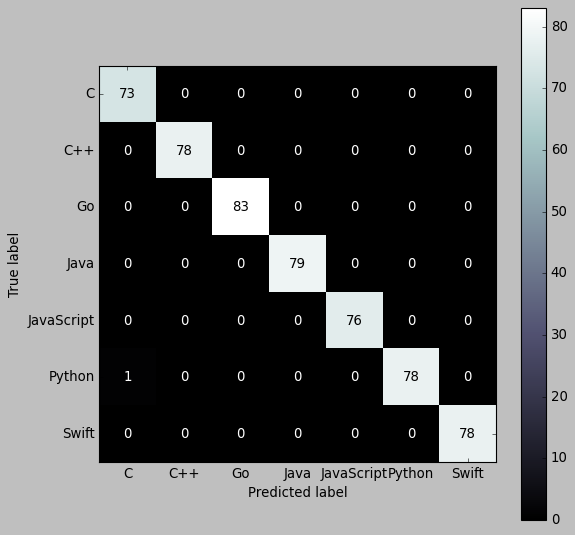

In [16]:
rf_clf = RandomForestClassifier(n_estimators=125,
                                max_depth=20,
                                random_state=36)
rf_vec = TfidfVectorizer(min_df=15, max_df=.35)
X = rf_vec.fit_transform(X_train)
rf_clf.fit(X, y_train)
rfmom = report_and_conf_matrix(rf_clf, X=X, y=y_train)

In [56]:
random_grid = {'n_estimators': [100, 200, 400],
               'max_depth': [20, 40, 60],
               'min_samples_split': [4, 5, 16],
               'min_samples_leaf': [2, 4, 8]}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter = 20, cv = 3, verbose=2,
                               random_state=36, n_jobs = -1)
rf_random.fit(X, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [57]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 60}

In [66]:
eli5.explain_weights(rf_clf, feature_names=list(rf_vec.vocabulary_.keys()))

Weight,Feature
0.0253 ± 0.0681,core
0.0203 ± 0.0703,rout
0.0201 ± 0.0635,account
0.0164 ± 0.0614,boolean
0.0162 ± 0.0708,social
0.0158 ± 0.0522,proper
0.0148 ± 0.0484,round
0.0133 ± 0.0550,line
0.0132 ± 0.0472,mark
0.0125 ± 0.0467,dictionari


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (6).

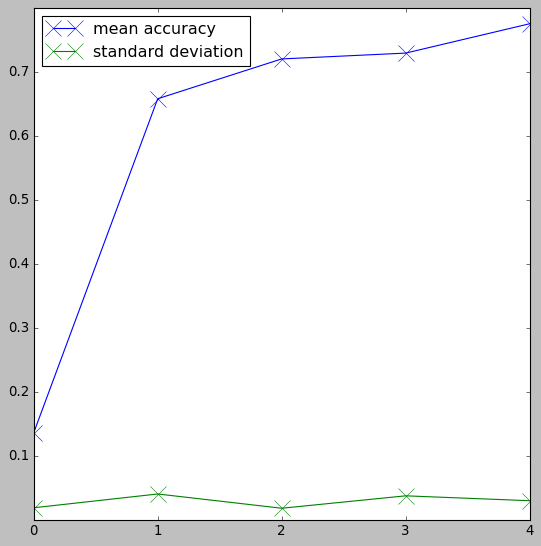

In [20]:
f, ax = plt.subplots()
plt.plot([clfmom, knnmom, nbmom, lrmom, rfmom], marker='x', ms=15)
plt.legend(["mean accuracy", "standard deviation"], loc='best')
ax.set_xticks(range(5))
ax.set_yticks([.1, .2, .3, .4, .5 , .6, .7])
ax.set_xticklabels(['Stratified \nrandom', 'kNN', 'Multinomial\n Naive Bayes','kNN','Logistic \nregression','Random \nforest'])
plt.ylabel('5-fold cross validation score')
plt.title('Choosing a best model from cross-validation scores')
plt.savefig('img/cvscores.png')
plt.show()

### Test set

              precision    recall  f1-score   support

           C       0.57      0.57      0.57        21
         C++       0.67      0.45      0.54        22
          Go       0.91      0.87      0.89        23
        Java       0.71      0.87      0.78        23
  JavaScript       0.86      0.86      0.86        21
      Python       0.62      0.70      0.65        23
       Swift       0.95      0.95      0.95        22

    accuracy                           0.75       155
   macro avg       0.76      0.75      0.75       155
weighted avg       0.76      0.75      0.75       155



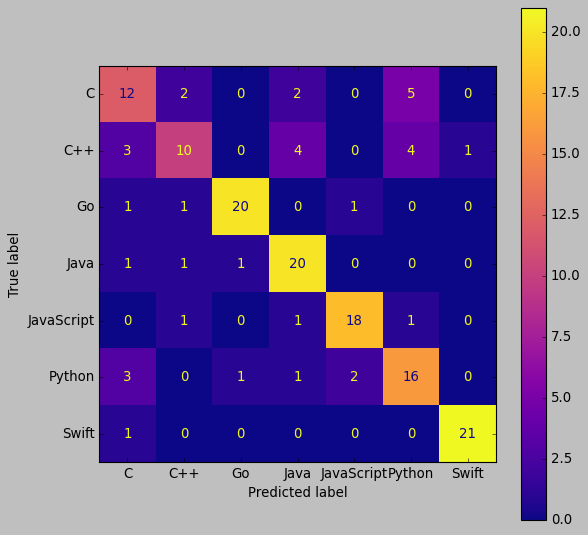

In [161]:
X = TfidfVectorizer(vocabulary=rf_vec.vocabulary_).fit_transform(X_test)
print(classification_report(y_test, rf_clf.predict(X)))
plot_confusion_matrix(rf_clf, X, y_test, cmap=cmap_test)
plt.savefig('img/rf_confmat.png')

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.129 (stdev 0.054)
---------------------------
[0.129 0.161 0.129 0.032 0.194]
              precision    recall  f1-score   support

           C       0.17      0.19      0.18        21
         C++       0.08      0.09      0.09        22
          Go       0.23      0.13      0.17        23
        Java       0.00      0.00      0.00        23
  JavaScript       0.20      0.24      0.22        21
      Python       0.07      0.09      0.08        23
       Swift       0.14      0.14      0.14        22

    accuracy                           0.12       155
   macro avg       0.13      0.12      0.12       155
weighted avg       0.13      0.12      0.12       155



[0.1290322580645161, 0.05397806622800488]

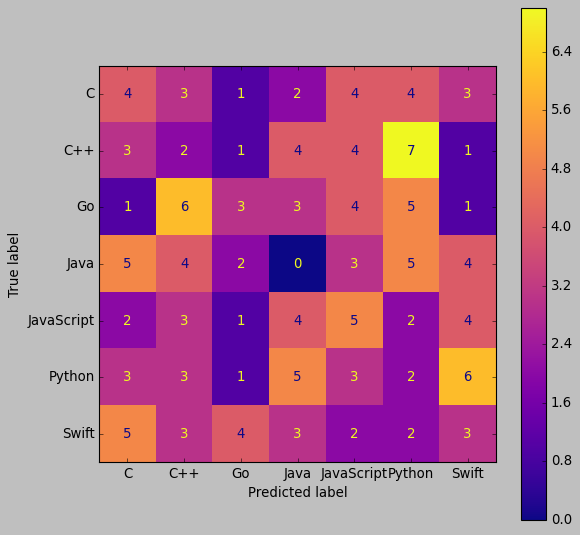

In [162]:
#dummy classifier
report_and_conf_matrix(clf, X=X, y=y_test, cmap=cmap_test)